Data Preparation

In [2]:
import os
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.model_selection import StratifiedKFold

Load Dataset

In [3]:
sepsis_data = pd.read_csv('dataset/sepsis_dataset.csv')
print("✅ Dataset Loaded Successfully")
print(sepsis_data.head(10))

✅ Dataset Loaded Successfully
   survival  THERAPY  PRAPACHE     AGE  BLGCS  ORGANNUM    BLIL6     BLLPLAT  \
0         0        1        19  42.921     15         1   301.80  191.000000   
1         1        1        48  68.818     11         2   118.90  264.156481   
2         0        1        20  68.818     15         2    92.80  123.000000   
3         0        1        19  33.174     14         2  1232.00  244.000000   
4         0        1        48  46.532      3         4  2568.00   45.000000   
5         0        0        21  56.098     14         1   162.65  137.000000   
6         1        0        19  68.818     15         2  2568.00   45.000000   
7         0        1        19  46.532     15         3  4952.00   92.000000   
8         0        1        22  56.098     15         3   118.90  148.601978   
9         1        1        19  56.098     10         3  2568.00  109.000000   

    BLLBILI  BLLCREAT  TIMFIRST      BLADL  blSOFA  
0  2.913416  1.000000     17.17   0.

Outcome = "survival"
Treatement = "THERAPY"

Data preprocessing and splitting

In [4]:
X = sepsis_data.drop(columns=['survival'])
y = sepsis_data['survival']

Single Random Forest

OOB predictions are used to estimate E(Y|T = realtreatment). Then, treatement is switched, it means that 1 becomes 0 and 0 becomes 1. We use again model to estimate E(Y|T = theothertreatment).
This is what computeTwin1() and computeTwin2() functions do.



In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=123)
rf.fit(X_train, y_train)

# T = realtreatment
Twin_1 = rf.predict_proba(X_test)[:, 1]

# switch treatment
X_test_counterfactual = X_test.copy()
X_test_counterfactual['THERAPY'] = 1 - X_test_counterfactual['THERAPY']

# T = theothertreatment
Twin_2 = rf.predict_proba(X_test_counterfactual)[:, 1]

# ITE
SRF_ITE = np.where(X_test['THERAPY'] == 1, Twin_1 - Twin_2, Twin_2 - Twin_1)

SRF = X_test.copy()
SRF['Outcome'] = y_test
SRF['Twin_1'] = Twin_1
SRF['Twin_2'] = Twin_2
SRF['ITE'] = SRF_ITE

# output_path = os.path.join("Results", "SimpleRandomForest.csv")
# SRF.to_csv(output_path, index=False)

Double Random Forest

E(Y|T =1) if Ti = 1 is estimated by OOB predictions from model_trt1. E(Y|T = 0) if Ti = 0 is estimated by OOB predictions from model_trt0. This is what computeTwin1() does.

Then E(Y|T = 1)if Ti = 0 isestimated by model_trt1. Then E(Y|T = 0) if Ti = 1 is estimated by model_trt1. This is what computeTwin2() does

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_trt1 = X_train[X_train['THERAPY'] == 1]
y_train_trt1 = y_train[X_train['THERAPY'] == 1]
X_train_trt0 = X_train[X_train['THERAPY'] == 0]
y_train_trt0 = y_train[X_train['THERAPY'] == 0]
X_test_trt1 = X_test[X_test['THERAPY'] == 1]
X_test_trt0 = X_test[X_test['THERAPY'] == 0]

model_trt1 = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=123)
model_trt1.fit(X_train_trt1, y_train_trt1)

model_trt0 = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=123)
model_trt0.fit(X_train_trt0, y_train_trt0)

twin1_scores = np.zeros(len(X_test))

twin1_scores[X_test['THERAPY'] == 1] = model_trt1.predict_proba(X_test_trt1)[:, 1]
twin1_scores[X_test['THERAPY'] == 0] = model_trt0.predict_proba(X_test_trt0)[:, 1]

twin2_scores = np.zeros(len(X_test))

twin2_scores[X_test['THERAPY'] == 1] = model_trt0.predict_proba(X_test_trt1)[:, 1]
twin2_scores[X_test['THERAPY'] == 0] = model_trt1.predict_proba(X_test_trt0)[:, 1]

DRF_ITE = np.zeros(len(X_test))

DRF_ITE[X_test['THERAPY'] == 1] = twin1_scores[X_test['THERAPY'] == 1] - twin2_scores[X_test['THERAPY'] == 1]
DRF_ITE[X_test['THERAPY'] == 0] = twin2_scores[X_test['THERAPY'] == 0] - twin1_scores[X_test['THERAPY'] == 0]

K Fold Random Forest

Twins are estimated by k-fold cross validation. A forest is computed on k-1/k of the data and then used to estimate twin1 and twin2 on 1/k of the left data

In [40]:
def compute_kfold_single_rf(X, y, T, treatment_col_name='THERAPY', k=5):
    
    p1_cv = np.zeros(len(X))
    p0_cv = np.zeros(len(X))
    
    kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=123)
    
    for fold_i, (train_index, val_index) in enumerate(kf.split(X, T)):
        
        X_train_fold = X.iloc[train_index].copy()
        y_train_fold = y.iloc[train_index]
        T_train_fold = T.iloc[train_index]
        
    
        X_train_fold[treatment_col_name] = T_train_fold
        
        rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=123)
        rf.fit(X_train_fold, y_train_fold)
        
        X_val_fold = X.iloc[val_index]
        
        X_val_forced_1 = X_val_fold.copy()
        X_val_forced_1[treatment_col_name] = 1
       
        X_val_forced_0 = X_val_fold.copy()
        X_val_forced_0[treatment_col_name] = 0
        
        p1_probs = rf.predict_proba(X_val_forced_1)[:, 1]
        p0_probs = rf.predict_proba(X_val_forced_0)[:, 1]
        
        
        p1_cv[val_index] = p1_probs
        p0_cv[val_index] = p0_probs

    
    ite_cv = p1_cv - p0_cv
    
    return p1_cv, p0_cv, ite_cv


P1_vec, P0_vec, KF_ITE = compute_kfold_single_rf(
    X, 
    y, 
    sepsis_data['THERAPY'], 
    treatment_col_name='THERAPY', 
    k=5
)

KF = sepsis_data.copy()
KF['P1_CV'] = P1_vec
KF['P0_CV'] = P0_vec
KF['ITE_CV'] = KF_ITE

Subgroups and plots

Regression Tree

Single Random Forest Method

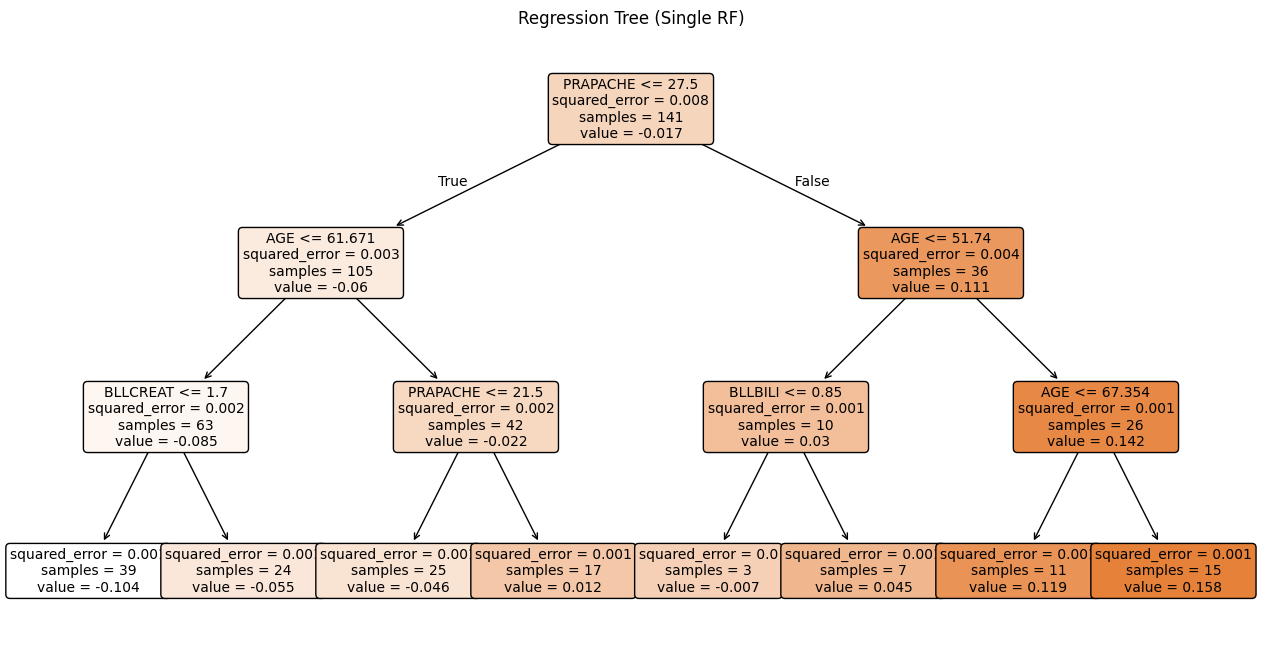

In [33]:
X_features = X_test.drop(columns=['THERAPY'])

reg_SRF = DecisionTreeRegressor(max_depth=3, min_samples_split=10, random_state=42)
reg_SRF.fit(X_features, SRF_ITE)

plt.figure(figsize=(16, 8))
plot_tree(
    reg_SRF,
    feature_names=X_features.columns,
    filled=True,        
    rounded=True,
    precision=3,
    fontsize=10
)

plt.title("Regression Tree (Single RF)")
plt.show()

Double Random Forest Method

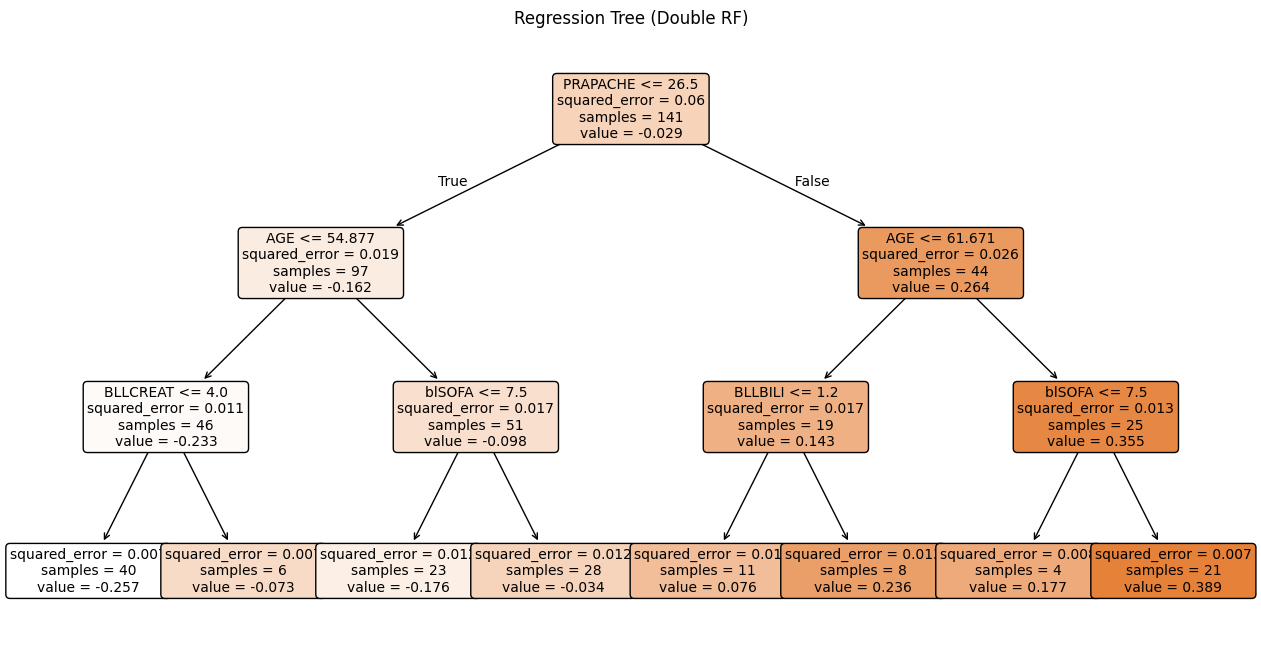

In [30]:
X_features = X_test.drop(columns=['THERAPY'], errors='ignore')

reg_DRF = DecisionTreeRegressor(max_depth=3, min_samples_split=10, random_state=42)
reg_DRF.fit(X_features, DRF_ITE)

plt.figure(figsize=(16, 8)) 
plot_tree(
    reg_DRF,
    feature_names=X_features.columns,
    filled=True,        
    rounded=True,
    precision=3,
    fontsize=10
)

plt.title("Regression Tree (Double RF)")
plt.show()

K Fold Method

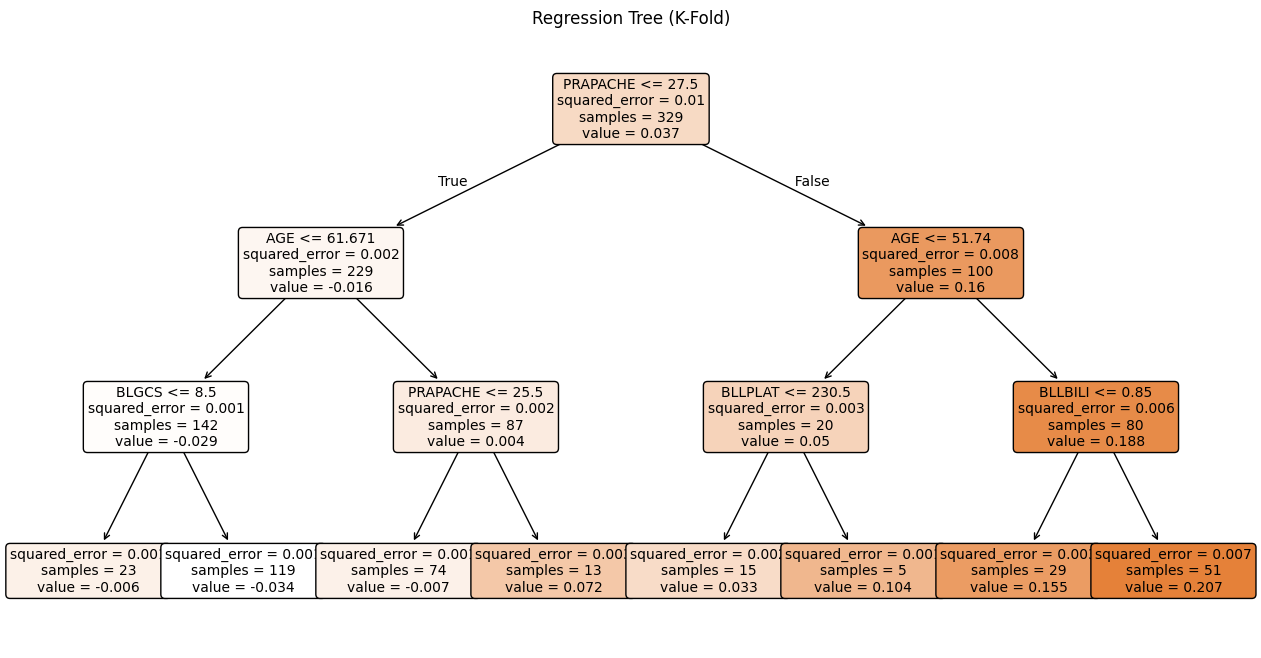

In [41]:
X_train_features = X_train.drop(columns=['THERAPY'], errors='ignore')

y_train_ite = KF.loc[X_train.index, 'ITE_CV']

reg_KF = DecisionTreeRegressor(max_depth=3, min_samples_split=10, random_state=42)
reg_KF.fit(X_train_features, y_train_ite)

plt.figure(figsize=(16, 8))
plot_tree(
    reg_KF,
    feature_names=X_train_features.columns,
    filled=True,        
    rounded=True,
    precision=3,
    fontsize=10
)

plt.title("Regression Tree (K-Fold)")
plt.show()

Classification Tree

$$
Z_i =
\begin{cases} 
1, & \text{if } ITE_i > 0 \\
0, & \text{otherwise}
\end{cases}
$$

Single Random Forest

In [34]:
thresholds = np.quantile(SRF_ITE, q=np.arange(0.5, 0.9, 0.1))

classification_trees_SRF = {}

for c in thresholds:
    Z_star = (SRF_ITE > c).astype(int)

    clf_SRF = DecisionTreeClassifier(max_depth=3, min_samples_split=10, random_state=42)
    clf_SRF.fit(X_features, Z_star)

    classification_trees_SRF[c] = clf_SRF

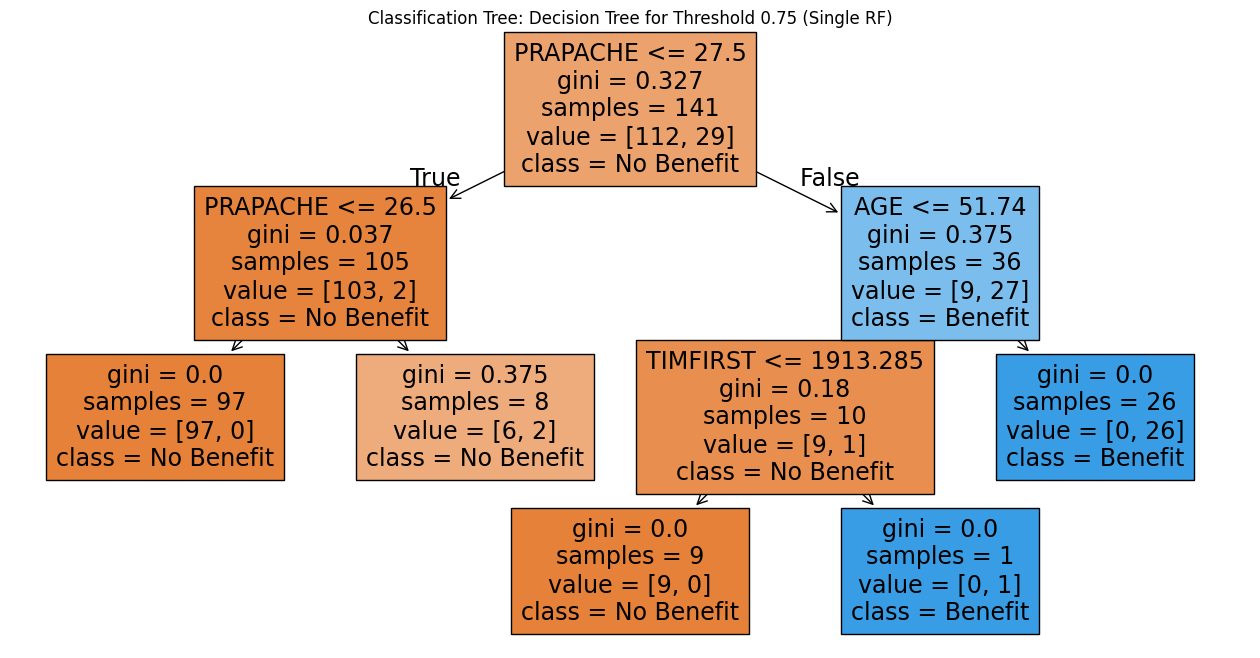

In [35]:
closest_threshold = 0.75
closest_key = min(classification_trees_SRF.keys(), key=lambda x: abs(x - closest_threshold))

plt.figure(figsize=(16, 8))
plot_tree(
    classification_trees_SRF[closest_key], 
    feature_names=X_features.columns, 
    class_names=["No Benefit", "Benefit"], 
    filled=True)
plt.title(f"Classification Tree: Decision Tree for Threshold {closest_threshold} (Single RF)")
plt.show()

Double Random Forest

In [13]:
classification_trees_DRF = {}

for c in thresholds:
    Z_star = (DRF_ITE > c).astype(int)

    clf_DRF = DecisionTreeClassifier(max_depth=3, min_samples_split=10, random_state=42)
    clf_DRF.fit(X_features, Z_star)

    classification_trees_DRF[c] = clf_DRF

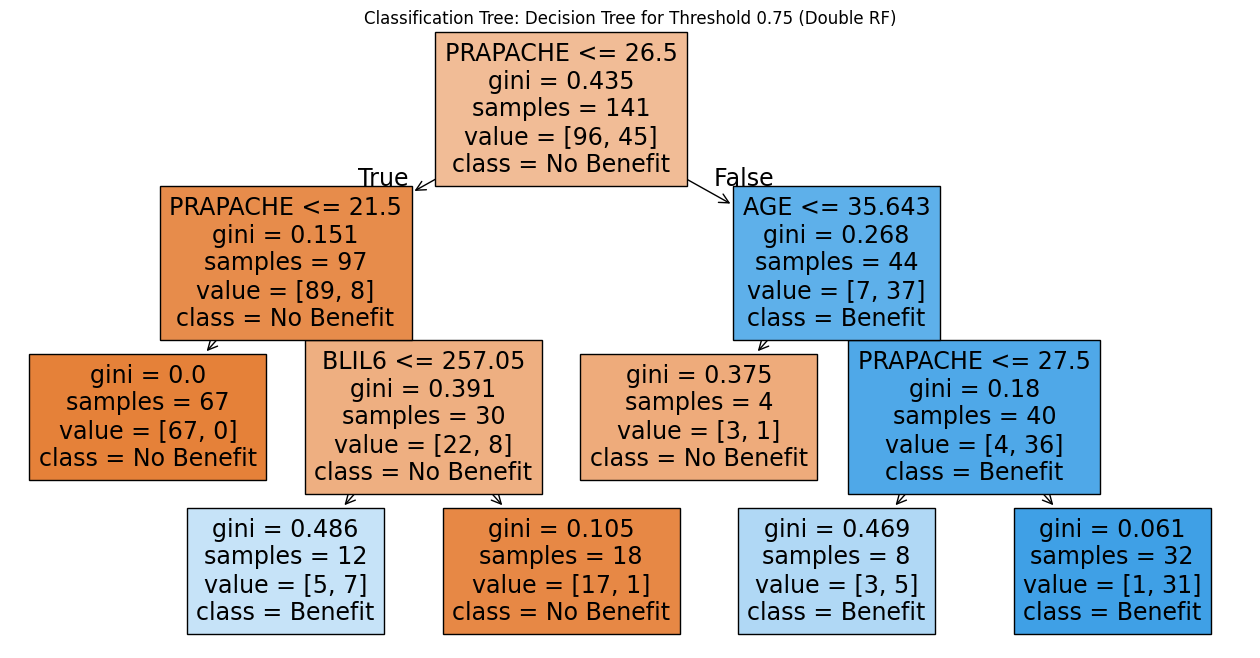

In [20]:
closest_key = min(classification_trees_DRF.keys(), key=lambda x: abs(x - closest_threshold))

plt.figure(figsize=(16, 8))
plot_tree(
    classification_trees_DRF[closest_key], 
    feature_names=X_features.columns, 
    class_names=["No Benefit", "Benefit"], 
    filled=True)
plt.title(f"Classification Tree: Decision Tree for Threshold {closest_threshold} (Double RF)")
plt.show()

K Fold

In [42]:
classification_trees_KF = {}

for c in thresholds:
    Z_star = (y_train_ite > c).astype(int)

    clf_KF = DecisionTreeClassifier(max_depth=3, min_samples_split=10, random_state=42)
    clf_KF.fit(X_train_features, Z_star)

    classification_trees_KF[c] = clf_KF

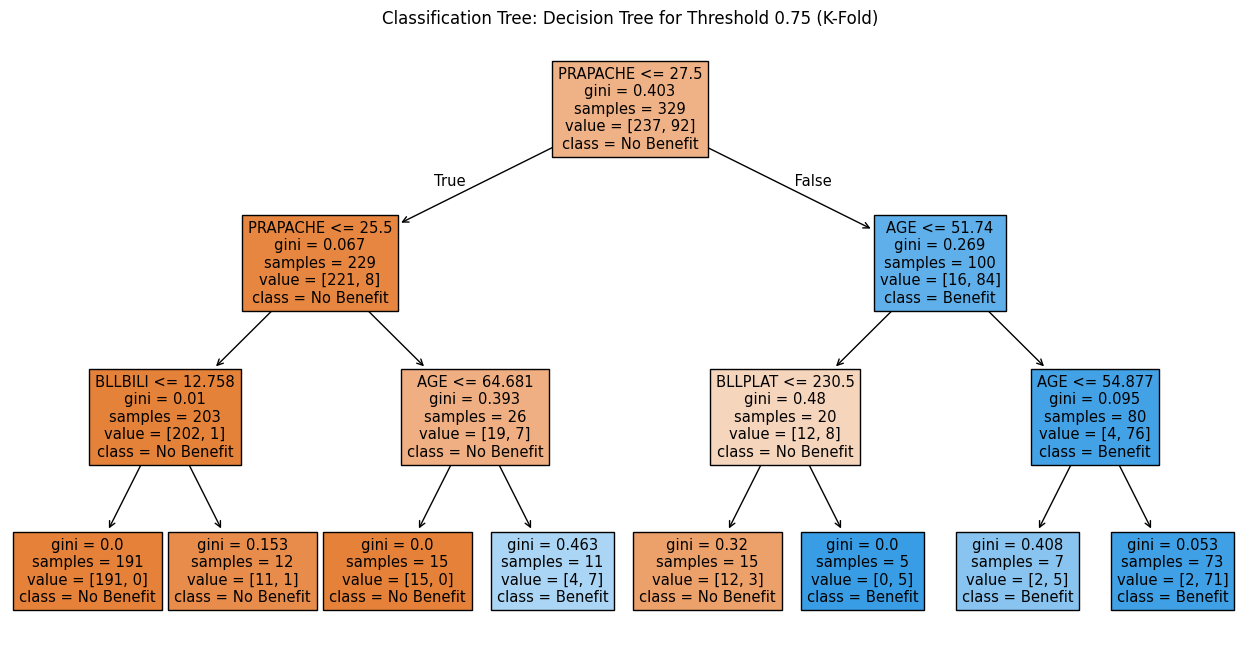

In [43]:
closest_key = min(classification_trees_KF.keys(), key=lambda x: abs(x - closest_threshold))

plt.figure(figsize=(16, 8))
plot_tree(
    classification_trees_KF[closest_key], 
    feature_names=X_features.columns, 
    class_names=["No Benefit", "Benefit"], 
    filled=True)
plt.title(f"Classification Tree: Decision Tree for Threshold {closest_threshold} (K-Fold)")
plt.show()

SHAP

Regression Tree Explanations

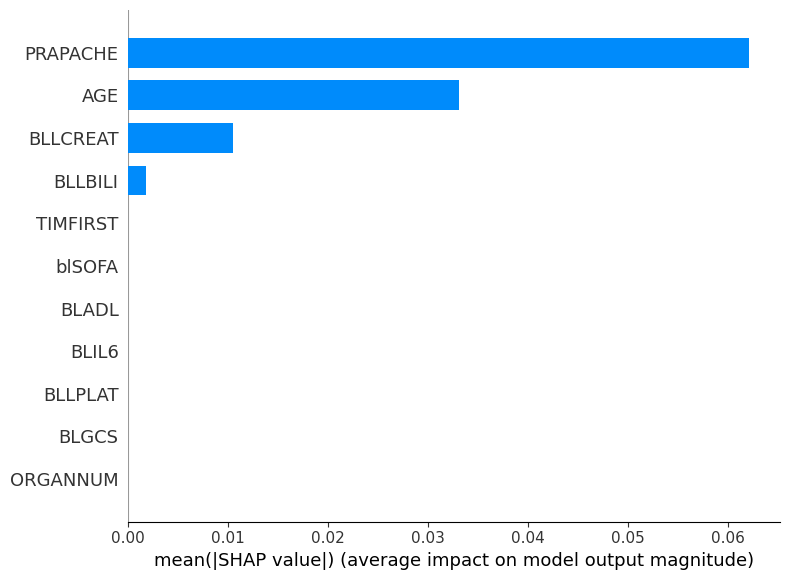

In [36]:
SRF_reg = shap.TreeExplainer(reg_SRF)
shap_SRF_reg = SRF_reg.shap_values(X_features)

shap.summary_plot(shap_SRF_reg, X_features, plot_type="bar", show=True)



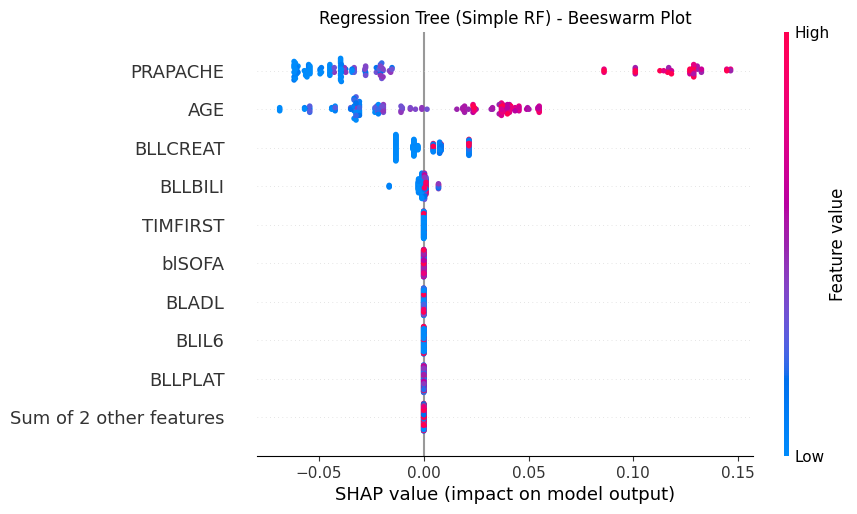

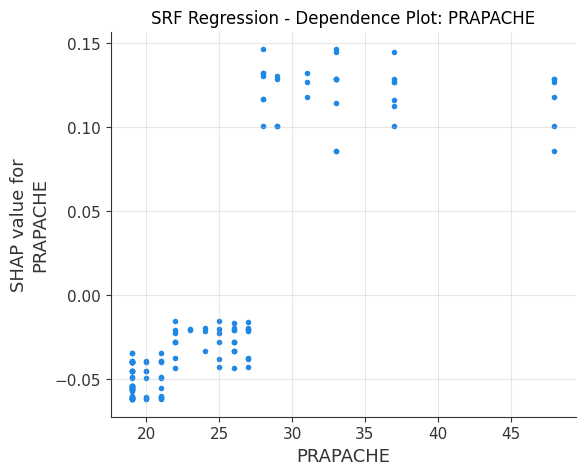

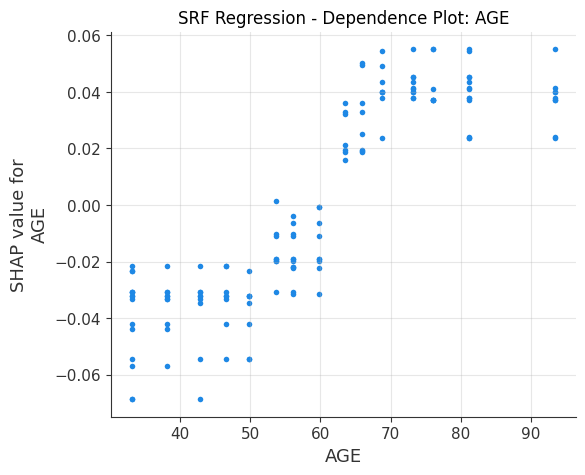

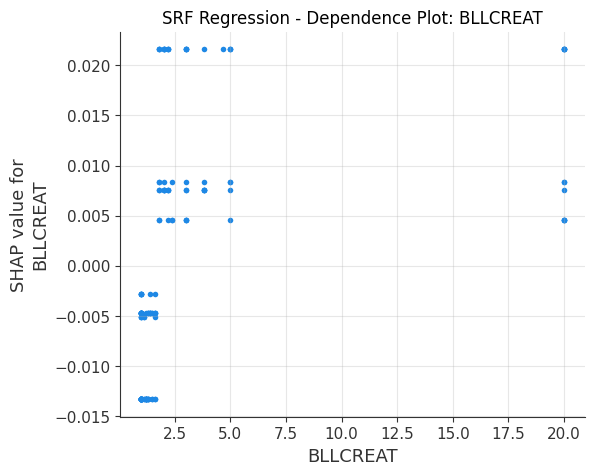

In [72]:
shap_explanation_SRF = shap.Explanation(
    values=shap_SRF_reg, 
    data=X_features.values, 
    feature_names=X_features.columns.tolist()
)

shap.plots.beeswarm(shap_explanation_SRF, show=False)
plt.title("Regression Tree (Simple RF) - Beeswarm Plot")
plt.show()

for i, feature_idx in enumerate(top_3_indices_SRF):
    shap.dependence_plot(
        feature_idx, 
        shap_SRF_reg, 
        X_features, 
        interaction_index=None, 
        show=False
    )
    plt.title(f"SRF Regression - Dependence Plot: {top_3_features_SRF[i]}")
    plt.grid(True, alpha=0.3)
    plt.show()

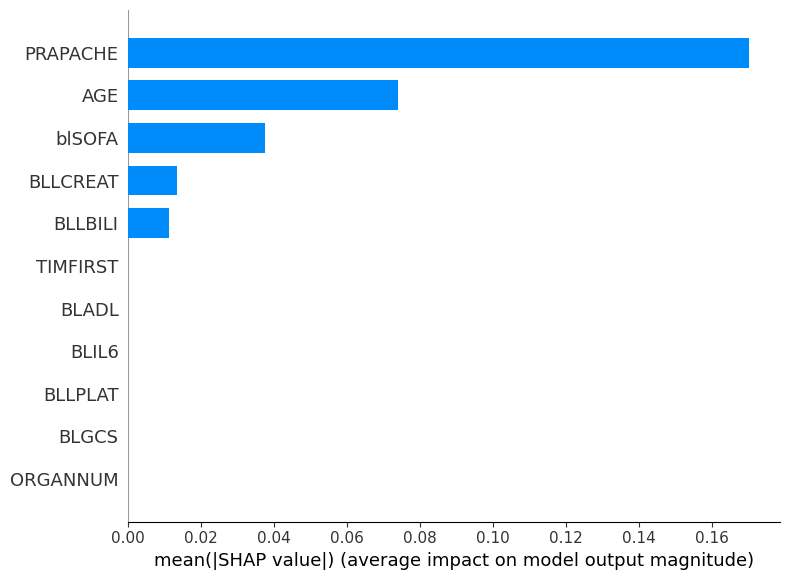

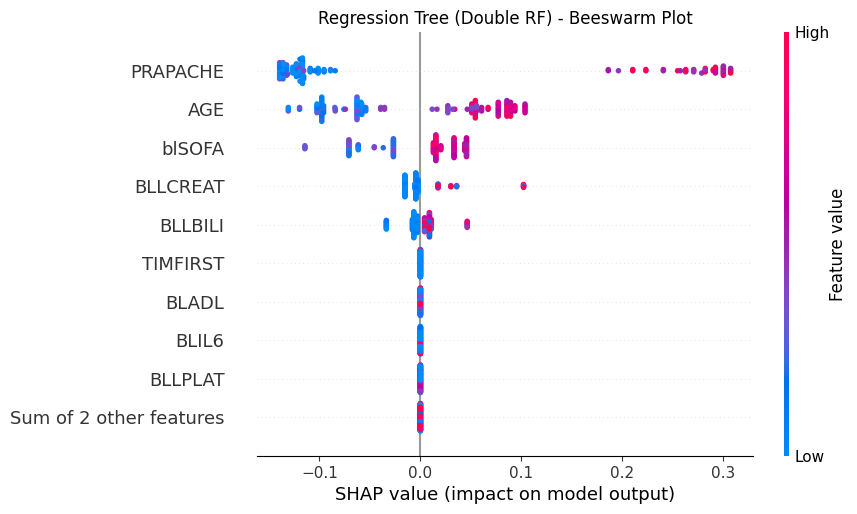

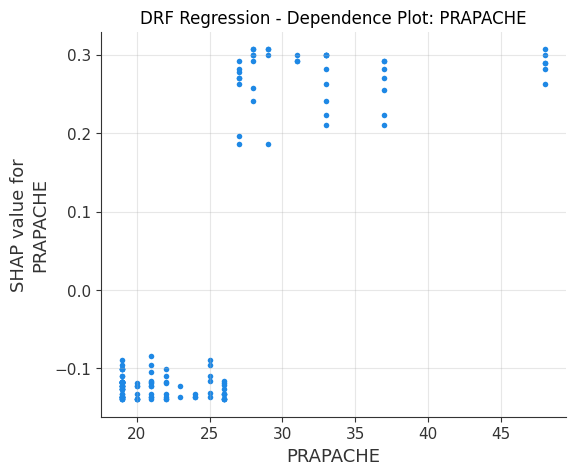

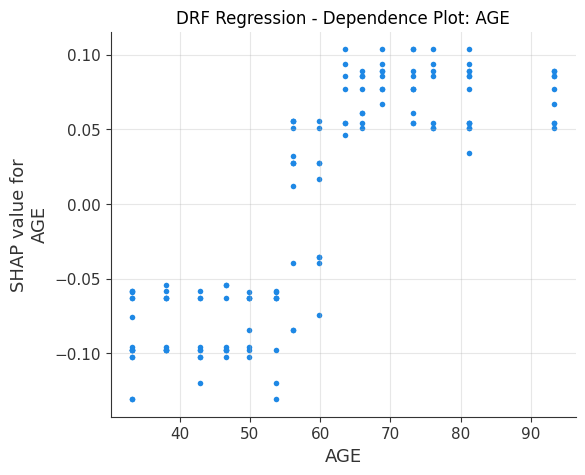

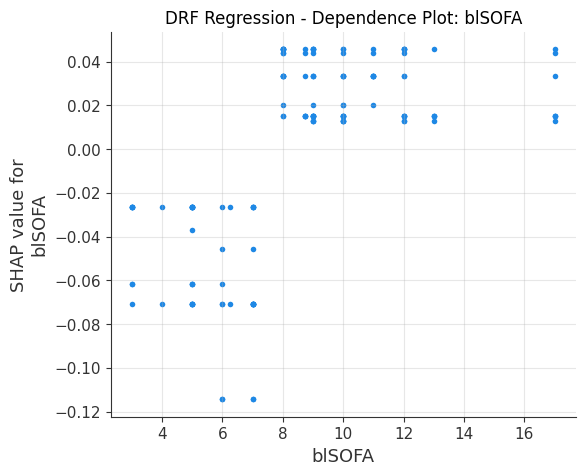

In [73]:
DRF_reg = shap.TreeExplainer(reg_DRF)
shap_DRF_reg = DRF_reg.shap_values(X_features)

shap.summary_plot(shap_DRF_reg, X_features, plot_type="bar", show=True)

shap_explanation_DRF = shap.Explanation(
    values=shap_DRF_reg, 
    data=X_features.values, 
    feature_names=X_features.columns.tolist()
)

shap.plots.beeswarm(shap_explanation_DRF, show=False)
plt.title("Regression Tree (Double RF) - Beeswarm Plot")
plt.show()

mean_abs_shap_DRF = np.abs(shap_DRF_reg).mean(axis=0)
top_3_indices_DRF = np.argsort(mean_abs_shap_DRF)[-3:][::-1]
top_3_features_DRF = X_features.columns[top_3_indices_DRF].tolist()

for i, feature_idx in enumerate(top_3_indices_DRF):
    shap.dependence_plot(
        feature_idx, 
        shap_DRF_reg, 
        X_features, 
        interaction_index=None, 
        show=False
    )
    plt.title(f"DRF Regression - Dependence Plot: {top_3_features_DRF[i]}")
    plt.grid(True, alpha=0.3)
    plt.show()

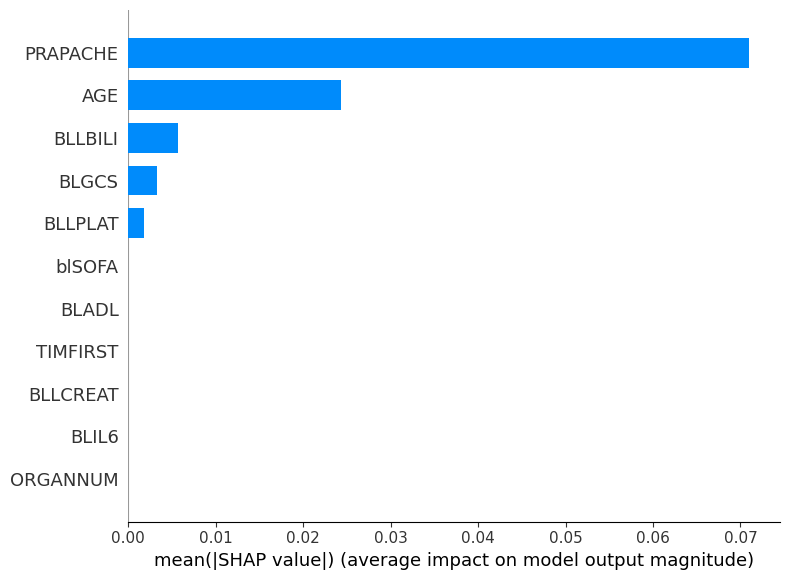

In [44]:
KF_reg = shap.TreeExplainer(reg_KF)
shap_KF_reg = KF_reg.shap_values(X_train_features)

shap.summary_plot(shap_KF_reg, X_train_features, plot_type="bar", show=True)

Classification Tree Explanations

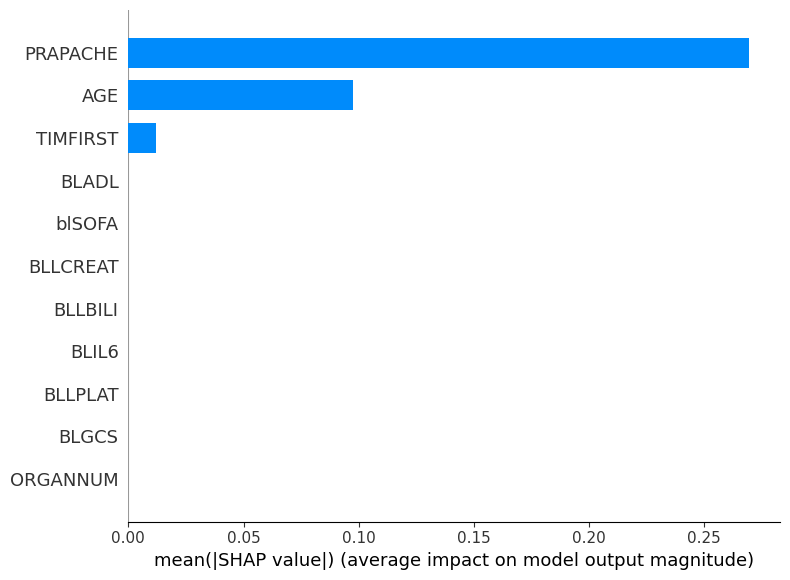

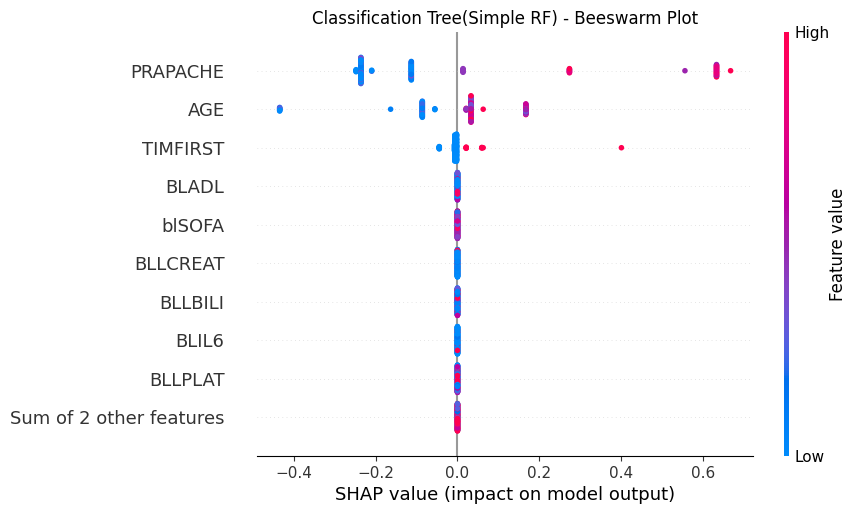

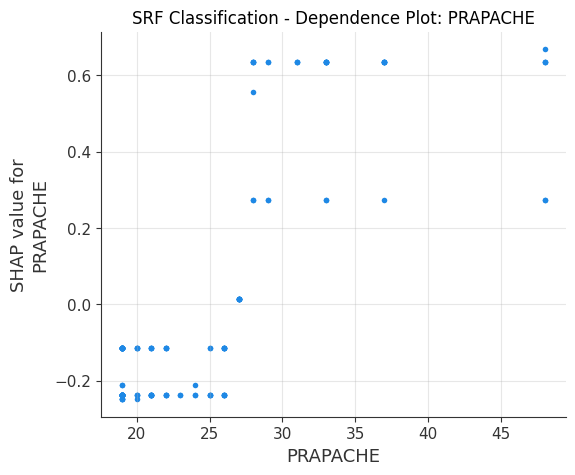

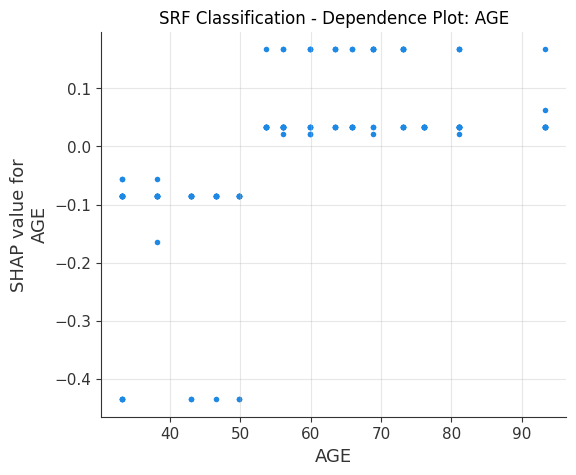

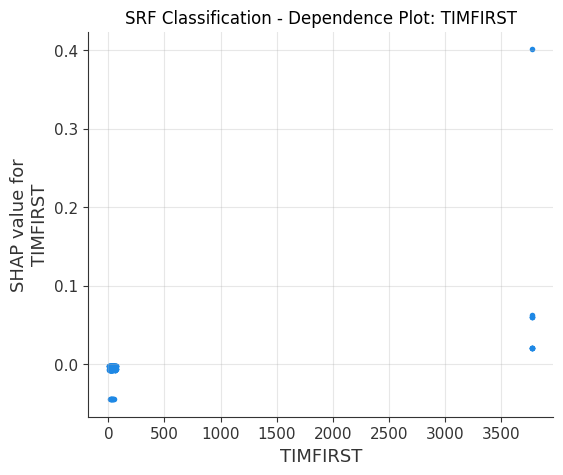

In [ ]:
SRF_class = shap.TreeExplainer(classification_trees_SRF[closest_key])
shap_SRF_class = SRF_class(X_features)
shap_values_SRF = shap_SRF_class[:, :, 1]

shap.summary_plot(shap_values_SRF, X_features, plot_type="bar", show=True)

mean_abs_shap = np.abs(shap_values_SRF.values).mean(axis=0)
top_3_indices_SRF_class = np.argsort(mean_abs_shap)[-3:][::-1]
top_3_features_SRF_class = X_features.columns[top_3_indices_SRF_class].tolist()

plt.figure(figsize=(10, 6))
shap.plots.beeswarm(shap_values_SRF, show=False)
plt.title("Classification Tree(Simple RF) - Beeswarm Plot")
plt.show()


for i, feature_idx in enumerate(top_3_indices_SRF_class):
    
    shap.dependence_plot(
        feature_idx, 
        shap_values_SRF.values, 
        X_features, 
        interaction_index=None, 
        show=False
    )
    plt.title(f"SRF Classification - Dependence Plot: {top_3_features_SRF_class[i]}")
    plt.grid(True, alpha=0.3)
    plt.show()

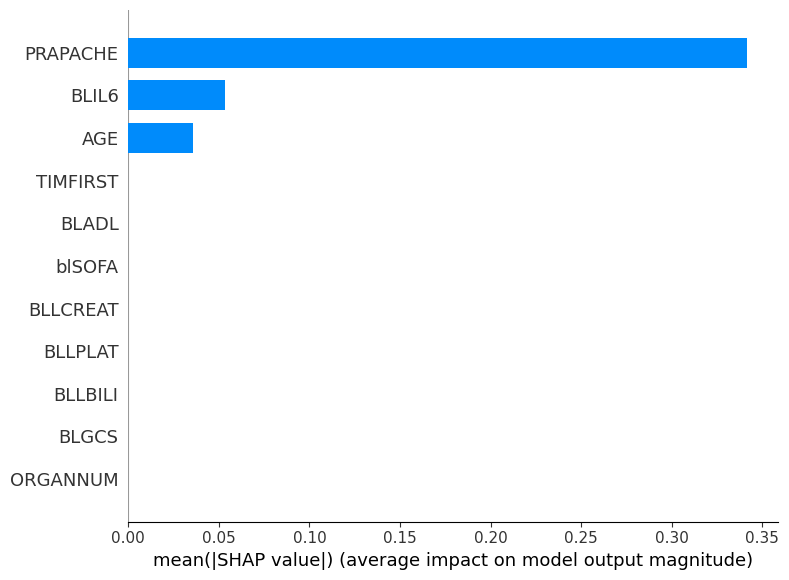

In [27]:
DRF_class = shap.TreeExplainer(classification_trees_DRF [closest_key])
shap_DRF_class = DRF_class(X_features)
shap_values_DRF = shap_DRF_class[:, :, 1]


shap.summary_plot(
    shap_values_DRF, 
    X_features, 
    plot_type="bar", 
    show=True)

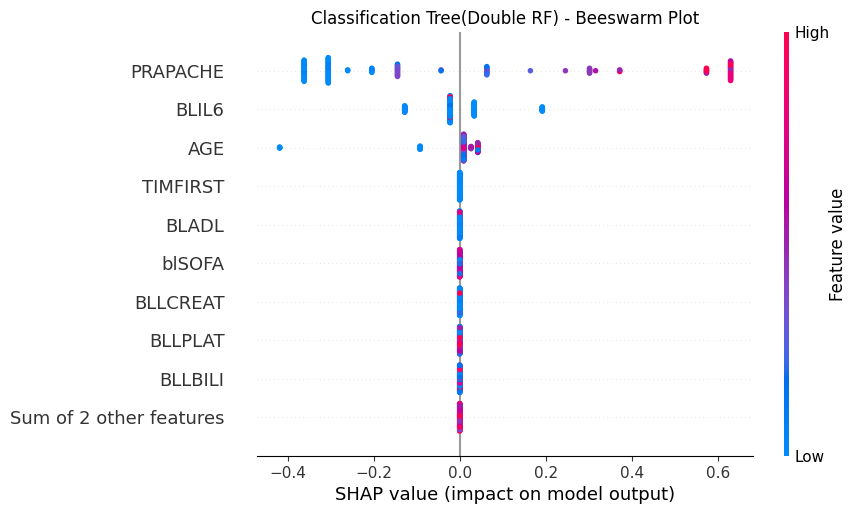

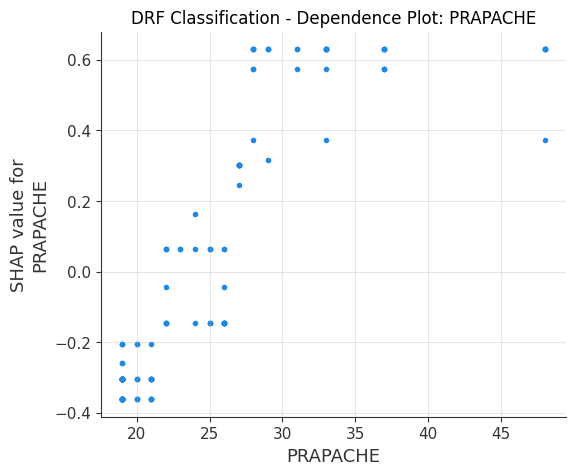

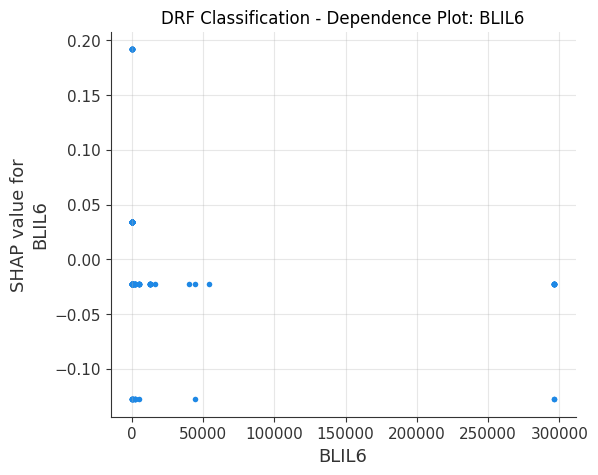

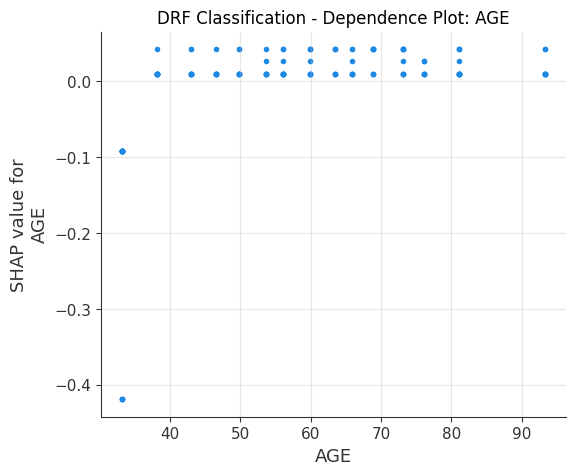

In [75]:
mean_abs_shap_drf = np.abs(shap_values_DRF.values).mean(axis=0)
top_3_indices_DRF_class = np.argsort(mean_abs_shap_drf)[-3:][::-1]
top_3_features_DRF_class = X_features.columns[top_3_indices_DRF_class].tolist()

plt.figure(figsize=(10, 6))
shap.plots.beeswarm(shap_values_DRF, show=False)
plt.title("Classification Tree(Double RF) - Beeswarm Plot")
plt.show()


for i, feature_idx in enumerate(top_3_indices_DRF_class):
    
    shap.dependence_plot(
        feature_idx, 
        shap_values_DRF.values, 
        X_features, 
        interaction_index=None, 
        show=False
    )
    plt.title(f"DRF Classification - Dependence Plot: {top_3_features_DRF_class[i]}")
    plt.grid(True, alpha=0.3)
    plt.show()

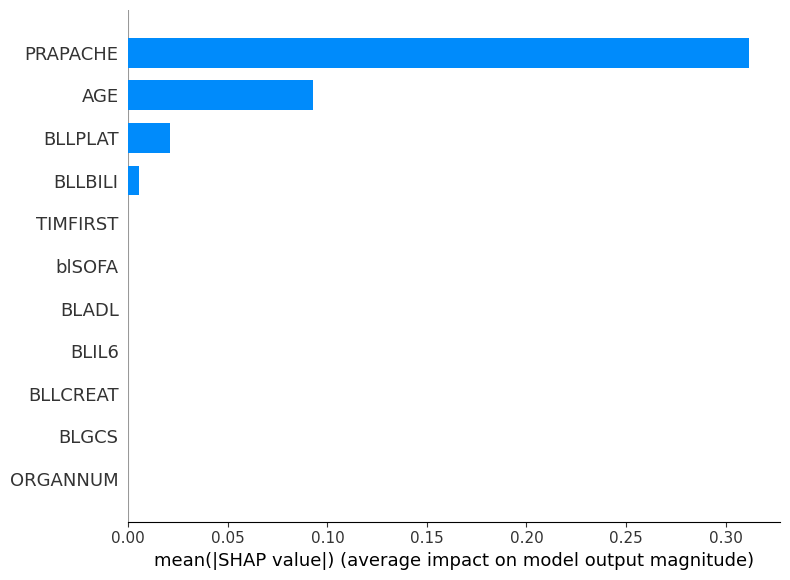

In [45]:
KF_class = shap.TreeExplainer(classification_trees_KF[closest_key])
shap_KF_class = KF_class(X_features)
shap_values_responder = shap_KF_class[:, :, 1]

plt.figure()
shap.summary_plot(
    shap_values_responder, 
    X_features, 
    plot_type="bar", 
    show=True)